<a href="https://colab.research.google.com/github/antonellagambarte/procesamiento_del_lenguaje_I/blob/main/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

In [ ]:
import urllib.request
import bs4 as bs

Para este trabajo, el libro elegido es "Viaje al centro de la tierra"

In [ ]:
# Descarga del corpus
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag )
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

### **Elección del tamaño de contexto**

Se decidió usar un valor de 100 caracteres ya que creo que permite incluir una o dos frases, lo que proporciona suficiente información para que el modelo aprenda dependencias significativas. A su vez, se busca evitar que las secuencias sean muy extensas y que dificulte la convergencia.

In [ ]:
# Tamaño de contexto
max_context_size = 100


# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)


# la longitud de vocabulario de caracteres es:
len(chars_vocab)


# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

### **Tokenización**

De acuerdo al enunciado, la tokenización debe ser por caracteres. Para ello se hace uso del diccionario construido en la celda anterior.

In [ ]:
tokenized_text = [char2idx[ch] for ch in article_text]

tokenized_text[:1000]

[7,
 30,
 68,
 7,
 11,
 34,
 53,
 5,
 67,
 29,
 34,
 7,
 39,
 75,
 7,
 11,
 30,
 7,
 53,
 15,
 2,
 34,
 7,
 11,
 30,
 7,
 0,
 4,
 61,
 46,
 32,
 7,
 53,
 5,
 7,
 63,
 17,
 34,
 32,
 7,
 30,
 68,
 7,
 42,
 10,
 34,
 6,
 30,
 37,
 34,
 10,
 7,
 68,
 5,
 11,
 30,
 67,
 41,
 10,
 34,
 44,
 20,
 32,
 7,
 30,
 67,
 63,
 10,
 21,
 7,
 40,
 10,
 58,
 42,
 5,
 11,
 15,
 53,
 30,
 67,
 63,
 30,
 7,
 15,
 7,
 37,
 18,
 7,
 16,
 34,
 29,
 15,
 10,
 32,
 7,
 37,
 5,
 63,
 18,
 15,
 11,
 34,
 7,
 30,
 67,
 7,
 30,
 68,
 7,
 67,
 1,
 53,
 30,
 10,
 34,
 7,
 0,
 64,
 7,
 11,
 30,
 7,
 68,
 15,
 7,
 20,
 69,
 67,
 5,
 29,
 8,
 37,
 63,
 10,
 15,
 37,
 37,
 30,
 32,
 7,
 18,
 67,
 15,
 40,
 7,
 11,
 30,
 7,
 68,
 15,
 37,
 7,
 44,
 15,
 68,
 68,
 30,
 37,
 7,
 53,
 58,
 37,
 7,
 63,
 10,
 15,
 11,
 5,
 44,
 5,
 34,
 67,
 15,
 68,
 30,
 37,
 7,
 11,
 30,
 68,
 7,
 41,
 15,
 10,
 10,
 5,
 34,
 7,
 15,
 67,
 63,
 5,
 29,
 18,
 34,
 7,
 11,
 30,
 7,
 16,
 15,
 53,
 41,
 18,
 10,
 29,
 34,
 22,
 7,
 53,
 15,

### **Estructuración del dataset**

In [ ]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))


# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]


tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]


tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]


X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [ ]:
X.shape

X[0,:10]
y[0,:10]
vocab_size = len(chars_vocab)

### **Callback para calculo de perplejidad**

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

### **Definición del modelo**

Se definieron 2 modelos. Uno con SimpleRNN y otro con LSTM.

El primero tiene una capa de embedding para convertir los tokens en vectores, despues una capa recurrente del tipo SimpleRNN con dropout de 0.1 y una capa densa con activación softmax.

El segundo tiene la capa de embedding, la capa recurrente tipo LSTM y la capa densa con activación softmax.

Cabe aclarar que debido a las limitaciones de recursos en Google Colab, estas fueron las únicas configuraciones que pude probar.



In [ ]:
model_simple = Sequential()

model_simple.add(Embedding(input_dim=vocab_size, output_dim=64, input_shape=(None,)))
model_simple.add(SimpleRNN(300, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_simple.add(Dense(vocab_size, activation='softmax'))
model_simple.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_simple.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 64)       │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 300)      │       109,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 77)       │        23,177 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,605 (537.52 KB)

 Trainable params: 137,605 (537.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.2220
 mean perplexity: 9.138482666685654 

Saved new model!
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 93s 56ms/step - loss: 2.2218
Epoch 2/20
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6107
 mean perplexity: 9.301974910762885 

1506/1506 ━━━━━━━━━━━━━━━━━━━━ 76s 50ms/step - loss: 1.6107
Epoch 3/20
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5325
 mean perplexity: 6.511493102728064 

Saved new model!
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 76s 50ms/step - loss: 1.5325
Epoch 4/20
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5004
 mean perplexity: 7.335815668106079 

1506/1506 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - loss: 1.5004
Epoch 5/20
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4821
 mean perplexity: 7.933024013349547 

1506/1506 ━━━━━━━━━━━━━━━━━━━━ 76s 50ms/step - loss: 1.4821
Epoch 6/20
1505/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4704
 mean perplexity: 5.076194075287366 

Saved new model!
1

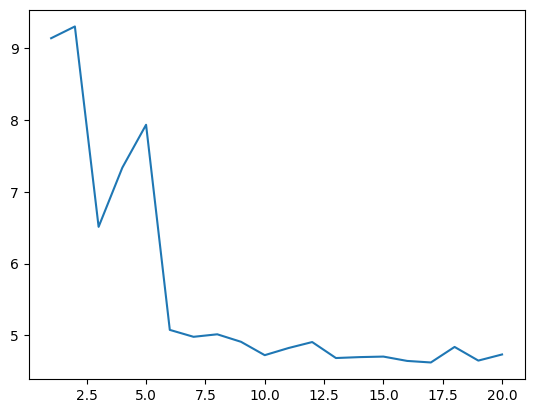

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model_simple.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)


import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()


# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
best_model_simple = keras.models.load_model('my_model.keras')

In [ ]:
model_lstm = Sequential()

model_lstm.add(Embedding(input_dim=vocab_size, output_dim=64, input_shape=(None,)))
model_lstm.add(LSTM(200, return_sequences=True))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_lstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 200)      │       212,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 77)       │        15,477 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,405 (907.83 KB)

 Trainable params: 232,405 (907.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1505/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4815
 mean perplexity: 6.970064883488961 

Saved new model!
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - loss: 2.4812
Epoch 2/20
1505/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8694
 mean perplexity: 6.031076299502085 

Saved new model!
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 48s 32ms/step - loss: 1.8694
Epoch 3/20
1505/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7004
 mean perplexity: 5.498726853162958 

Saved new model!
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 48s 32ms/step - loss: 1.7004
Epoch 4/20
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5957
 mean perplexity: 5.284773329102742 

Saved new model!
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 55s 36ms/step - loss: 1.5957
Epoch 5/20
1504/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5236
 mean perplexity: 5.286739708947354 

1506/1506 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - loss: 1.5236
Epoch 6/20
1505/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4725
 mean perplexity: 5.47

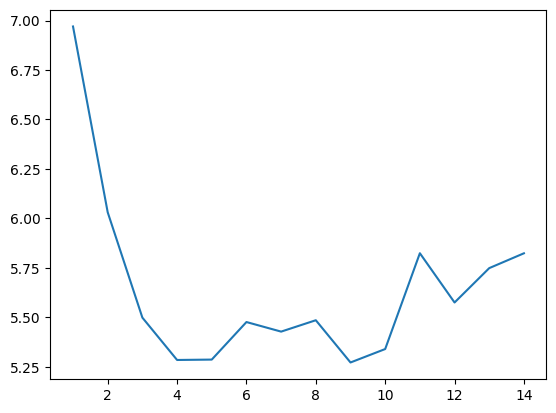

In [ ]:
history_ppl = []
hist = model_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)


import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()


# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


Como se observa en el gráfico, a partir de la época 9 comienza a existir un overfitting.

Para intentar mejorar los resultados, se podría probar otra configuración agregando una capa adicional de LSTM junto con dropout.

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model_lstm.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Generación de secuencias

In [ ]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [ ]:

input_text='habia una vez'

generate_seq(model_lstm, input_text, max_length=max_context_size, n_words=30)

Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [ ]:

from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [ ]:

# predicción con beam search
salidas = beam_search(model_lstm,num_beams=10,num_words=20,input="habia una vez")

In [ ]:

salidas[0]

array([54, 55, 44, 19, 55, 48, 34, 22, 55, 48, 59, 27, 57, 48, 68, 34, 27,
       48, 22, 50,  4, 48, 54, 55, 44,  0, 55, 43, 50,  4, 48, 68, 34])

In [ ]:

# veamos las salidas
decode(salidas[0])

'habia una vez que nos habíamos qu'